In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)
library(janitor)
library(data.table)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following objects ar

In [3]:
#Load in the avana bed file
setwd("../data")
avana.bed = read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 

total.avana.guides = avana.bed %>% pull(sgrna) %>% unique() %>% length()

In [ ]:
#Create a special bed file for filtering SNPs
avana.bed.for.filtering = avana.bed %>%
mutate(start = start - 10, .after = start) %>%
mutate(end = end + 10, .after = end)

#Write the bed file
setwd("../data")
write.table(avana.bed.for.filtering, "avana_filtering_bed_file.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)

In [4]:
#Load in the variant calls
setwd("../data")
all.ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t")


#Load in the sample names
setwd("../data")
ccle.sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(V1)


#Build a nice-looking dataset
formatted.avana.ccle.variant.calls = all.ccle.variant.calls %>%
rename("snp" = 2, "qual" = 7) %>%
filter(qual %in% "PASS") %>%
select(-1, -2, -4, -5, -6, -qual, -8, -9)

colnames(formatted.avana.ccle.variant.calls) = c("snp", ccle.sample.names)


#Melt the dataset and re-format the variant call encoding
melted.avana.ccle.variant.calls = formatted.avana.ccle.variant.calls %>%
melt(id = "snp") %>%
mutate(value = gsub(":.*", "", value)) %>%
mutate(value = gsub("0\\|0", "0", value)) %>%
mutate(value = gsub("0\\|1", "1", value)) %>%
mutate(value = gsub("1\\|0", "1", value)) %>%
mutate(value = gsub("1\\|1", "2", value)) %>%
rename("sample" = 2, "status" = 3) %>%
separate(snp, sep = ":", into = c("chr", "pos", "ref", "alt")) %>%
select(-ref, -alt) %>%
mutate("snp" = paste(chr, ":", pos, sep = ""), .before = 1)

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(.). In the next version, this warning will become an error.”


In [5]:
#Create a megabed that has all possible guide positions
avana.megabed = avana.bed %>% 
apply(1, function(x){
    
    #define some variables
    chr.of.interest = x[1]
    start.pos.of.interest = x[2]
    end.pos.of.interest = x[3]
    sgrna.of.interest = x[4]
    
    #build some vectors
    sequence.vector = seq(from = start.pos.of.interest, to = end.pos.of.interest, by = 1)
    chr.vector = rep(chr.of.interest, length(sequence.vector))
    sgrna.vector = rep(sgrna.of.interest, length(sequence.vector))
    
    #assemble the dataframe
    df.to.export = cbind(chr.vector, sequence.vector, sgrna.vector) %>% data.frame()
    
    #export the data frame
    return(df.to.export)
    
}) %>%
do.call(rbind, .) %>%
rename("chr" = 1, "pos" = 2, "sgrna" = 3) %>%
mutate("snp" = paste(chr, ":", pos, sep = ""), .before = chr)

In [6]:
#Annotate melted.avana.ccle.variant.calls so that is has the affected guide
annotated.avana.ccle.variant.calls = melted.avana.ccle.variant.calls %>%
rename("snp_status" = status) %>%
mutate("affected_sgrna" = plyr::mapvalues(from = avana.megabed$snp, to = avana.megabed$sgrna, snp, warn_missing = FALSE)) %>%
filter(!grepl('chr', affected_sgrna)) %>%
mutate(snp_status = as.numeric(snp_status))

In [7]:
#Load in the pre-correction chronos scores
setwd("../data")
chronos.22q1 = read.table("22q1_crispr_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

#Get a vector of samples in this dataset
chronos.22q1.samples = chronos.22q1 %>% pull(sample)

#Get vector of snp6 samples
snp6.samples = melted.avana.ccle.variant.calls %>% pull(sample) %>% unique()

#Get a vector of intersecting samples between chronos and snp6
samples.to.keep = intersect(chronos.22q1.samples, snp6.samples)

In [9]:
#Calculate the total number of affected guides
total.affected.guides = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% samples.to.keep) %>%
pull(affected_sgrna) %>%
unique() %>%
length()

print(paste("The total number of affected guides is:", total.affected.guides))



#Calculate the total number of guides that are affected in at least 10 cell lines
total.affected.in.10.lines = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% samples.to.keep) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
filter(unique_count >= 10) %>%
pull(affected_sgrna) %>%
unique() %>%
length()

print(paste("The total number of guides affected in at least 10 cell lines is:", total.affected.in.10.lines))



#Calculate the percent of guides that are affected
percent.of.guides.affected = (total.affected.guides/total.avana.guides)*100

print(paste(percent.of.guides.affected, "% of guides are affected in at least one cell line.", sep = ""))



#calculate the precent of guides that are affected in at least 10 cell lines
percent.of.guides.affected.in.10.lines = (total.affected.in.10.lines/total.avana.guides)*100

print(paste(percent.of.guides.affected.in.10.lines, "% of guides are affected in at least one cell line.", sep = ""))

[1] "The total number of affected guides is: 3368"
[1] "The total number of guides affected in at least 10 cell lines is: 3209"
[1] "4.57627348940854% of guides are affected in at least one cell line."
[1] "4.36023207467696% of guides are affected in at least one cell line."


In [10]:
#Load in the single-guide p-value matrix
setwd("../data")
single.guide.pval.matrix = read.table("snv_position_single_guide_finaldf.txt", sep = "\t", header = T) %>%
mutate(position = factor(position, levels = 0:22))

#Get a vector with all of the guides that have a significant association
all.significant.guides = single.guide.pval.matrix %>%
filter(fdr <= 0.05) %>%
pull(sgrna) %>%
unique()

In [11]:
#Get a vector that contains the guides that are affected in at least 10 cell lines
guides.affected.in.10.lines = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
filter(unique_count >= 10) %>%
pull(affected_sgrna) %>%
unique()


#Of the guides with a SNP, calculate how many are also significant
number.affected.and.significant = setdiff(guides.affected.in.10.lines, all.significant.guides) %>% length()
percent.affected.and.significant = (number.affected.and.significant/total.affected.in.10.lines)*100
print(paste("the percent of guides that are affected by a snp in 10 lines and have a significant association with guide dependency score is:", percent.affected.and.significant))



#Of the above guides, what fraction of DepMap do they make up?
fraction.of.depmap = (number.affected.and.significant/total.avana.guides)*100
print(paste("the fraction of depmap that is affected is:", fraction.of.depmap))

[1] "the percent of guides that are affected by a snp in 10 lines and have a significant association with guide dependency score is: 56.2168899968838"
[1] "the fraction of depmap that is affected is: 2.45118686902999"


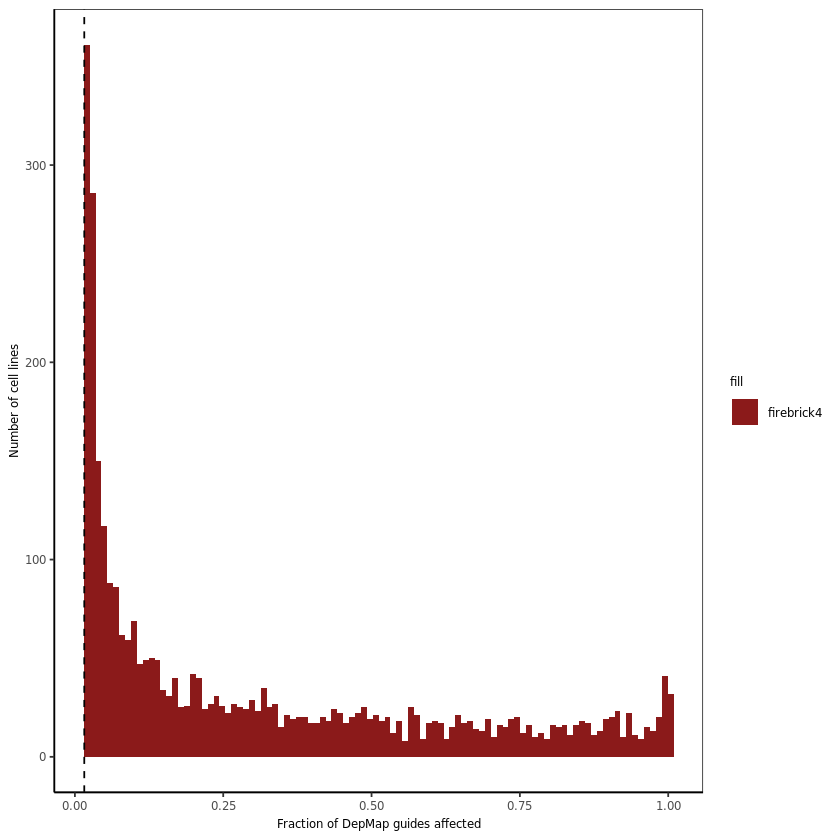

In [13]:
#Create a new distribution plot
df.for.distribution.plot = annotated.avana.ccle.variant.calls %>%
filter(snp_status >= 1) %>%
filter(sample %in% all_of(samples.to.keep)) %>%
group_by(affected_sgrna) %>%
summarize("unique_count" = n_distinct(sample)) %>%
mutate("fraction_affected" = unique_count/length(samples.to.keep))


#Plot the plot
df.for.distribution.plot %>%
filter(unique_count >= 10) %>%
ggplot(aes(x = fraction_affected, fill = "firebrick4")) +
geom_histogram(bins = 100) +

geom_vline(xintercept = 10/length(samples.to.keep), linetype = 2) +

theme_bw() +

scale_fill_manual(values = "firebrick4") +


theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +


theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Number of cell lines") +
xlab("Fraction of DepMap guides affected")

#Export the figure
setwd('../output')
ggsave("figure_3b.pdf", width = 4, height = 2)

In [14]:
#Also write the table
df_for_export = df.for.distribution.plot %>%
filter(unique_count >= 10)


setwd("../output")
write.table(df_for_export, "figure_3b_distribution_table.txt", sep = "\t", row.names = FALSE, quote = FALSE)